In [21]:
cd /home/edrewke/FHDeX/exec/immersed_boundary/flagellum/

/home/edrewke/FHDeX/exec/immersed_boundary/flagellum


In [1]:
import sys, os, os.path
import glob

import scipy as sp
import numpy as np

import matplotlib
import matplotlib.pyplot as pp

import yt
from yt.frontends.boxlib.data_structures import AMReXDataset

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
class SoA:
    _pref = "particle_"
    _pos  = "position_"
    _vel  = "vel"
    # New here
    _id   = "id"
    _cpu  = "cpu"
    _id_0 = "id_0"
    _cpu_0 = "cpu_0"
    
    def __init__(self, data):
        str_pos = self._pref+self._pos
        self.px = np.array(data[str_pos + "x"])
        self.py = np.array(data[str_pos + "y"])
        self.pz = np.array(data[str_pos + "z"])

        str_vel = self._pref+self._vel
        self.vx = np.array(data[str_vel + "x"])
        self.vy = np.array(data[str_vel + "y"])
        self.vz = np.array(data[str_vel + "z"])

        str_id = self._pref+self._id
        self.id = np.array(data[str_id])
        str_cpu = self._pref+self._cpu
        self.cpu = np.array(data[str_cpu])
        
        str_id_0 = self._pref+self._id_0
        self.id_0 = np.array(data[str_id_0])
        str_cpu_0 = self._pref+self._cpu_0
        self.cpu_0 = np.array(data[str_cpu_0])
 
    # new here
    def __str__(self):
        return "{pos:"  + str(self.px) + "," + str(self.py) + "," + str(self.pz) + \
              "; vel:"  + str(self.vx) + "," + str(self.vy) + "," + str(self.vz) + \
              "; id:"   + str(self.id) + ", cpu:" + str(self.cpu) + ", id_0:" + str(self.id_0) + ", cpu_0:" + str(self.cpu_0) + "," + "}"


    def __repr__(self):
        return str(self)


# new here
class Particle:
    def __init__(self, px, py, pz, vx, vy, vz, id, cpu, id_0, cpu_0):
        self.pos = np.array([px, py, pz])
        self.vel = np.array([vx, vy, vz])
        self.id  = np.array(id)
        self.cpu  = np.array(cpu)
        self.id_0  = np.array(id_0)
        self.cpu_0  = np.array(cpu_0)

    def __str__(self):
        return "P(" + str(self.pos) + "," + str(self.vel) + "," + str(self.id) + "," + str(self.cpu) + "," + str(self.id_0) + "," + str(self.cpu_0) + "," + ")"
    

    def __repr__(self):
        return str(self)


class AoS:
    def __init__(self, amrex_data):
        self.particles = list()
        soa = SoA(amrex_data)
        # new here        
        data = zip(soa.px, soa.py, soa.pz, soa.vx, soa.vy, soa.vz, soa.id, soa.cpu, soa.id_0, soa.cpu_0)
        for elt in data:
            self.particles.append(Particle(* elt))




In [4]:
data_root = "."
data_dir  = "."

In [5]:
data_path = os.path.join(data_root, data_dir)

In [478]:
n_fill   = 5
prefix   = "plt"
file_fmt = prefix + "{:0" + str(n_fill) + "d}"

In [927]:
data_glob  = os.path.join(data_path, prefix + "*")
data_files = glob.glob(data_glob)
data_files.sort()
#print(data_files)
len(data_files)

470


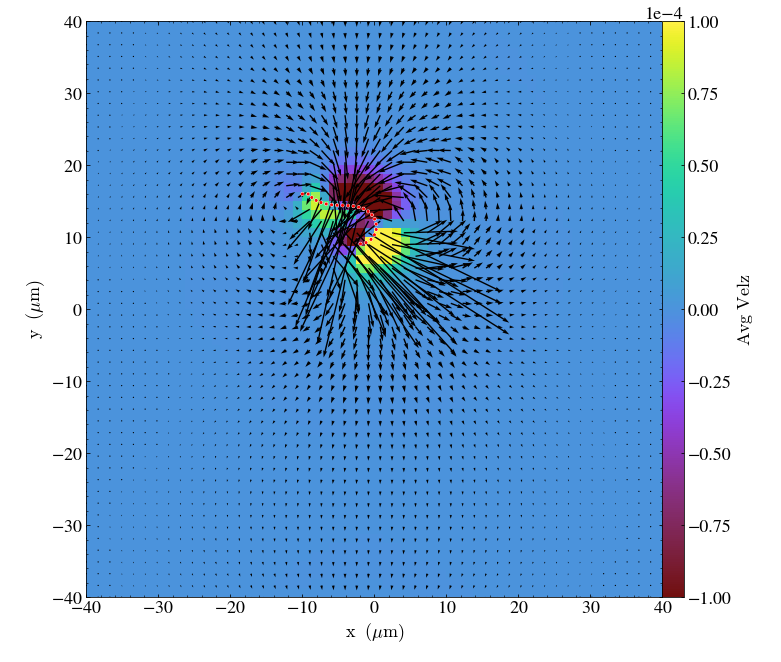

In [928]:
yt.funcs.mylog.setLevel(50)

n_marker_skip = 1
marker_rad = 2e-5
velz_max   = 1e-4
plot_index = -1

ds = yt.load(data_files[plot_index])

amrex_ds = AMReXDataset(data_files[plot_index])
ad = amrex_ds.all_data()
aos = AoS(ad)

slc = yt.SlicePlot(ds, "z", "avg_velz")

slc.set_log("avg_velx", False)
slc.set_log("avg_vely", False)
slc.set_log("avg_velz", False)
slc.set_zlim('avg_velz', -velz_max, velz_max)

slc.annotate_quiver("avg_velx", "avg_vely")

for j, part in enumerate(aos.particles[::n_marker_skip]):
    p = part.pos
    p.tolist()
    slc.annotate_sphere(p, radius=(marker_rad), circle_args={'fill':True, 'color':'white'})
    slc.annotate_sphere(p, radius=(marker_rad*0.7), circle_args={'fill':True, 'color':'red'})
    #slc.annotate_marker(p, plot_args={'color':'black'})

slc.show()

In [929]:
yt.funcs.mylog.setLevel(50)

for i, data_file in enumerate(data_files):
    frame_file = "frame_" + str(i).zfill(5) + ".png"

    if os.path.isfile(frame_file):
        continue
    else:
        print(f"Working on: {frame_file}")

    ds = yt.load(data_file)
    
    amrex_ds = AMReXDataset(data_file)
    ad = amrex_ds.all_data()
    aos = AoS(ad)
    
    n_marker_skip = 1
    marker_rad = 2e-5
    velz_max   = 1e-4

    slc = yt.SlicePlot(ds, "z", "avg_velz")
    
    slc.set_log("avg_velx", False)
    slc.set_log("avg_vely", False)
    slc.set_log("avg_velz", False)
    slc.set_zlim('avg_velz', -velz_max, velz_max)
    
    slc.annotate_quiver("avg_velx", "avg_vely")
    
    for j, part in enumerate(aos.particles[::n_marker_skip]):
        p = part.pos
        p.tolist()
        slc.annotate_sphere(p, radius=(marker_rad), circle_args={'fill':True, 'color':'white'})
        slc.annotate_sphere(p, radius=(marker_rad*0.7), circle_args={'fill':True, 'color':'red'})
        #slc.annotate_marker(p,plot_args={'color':'black'})
    
    slc.save(frame_file)

Working on: frame_00398.png
Working on: frame_00399.png
Working on: frame_00400.png
Working on: frame_00401.png
Working on: frame_00402.png
Working on: frame_00403.png
Working on: frame_00404.png
Working on: frame_00405.png
Working on: frame_00406.png
Working on: frame_00407.png
Working on: frame_00408.png
Working on: frame_00409.png
Working on: frame_00410.png
Working on: frame_00411.png
Working on: frame_00412.png
Working on: frame_00413.png
Working on: frame_00414.png
Working on: frame_00415.png
Working on: frame_00416.png
Working on: frame_00417.png
Working on: frame_00418.png
Working on: frame_00419.png
Working on: frame_00420.png
Working on: frame_00421.png
Working on: frame_00422.png
Working on: frame_00423.png
Working on: frame_00424.png
Working on: frame_00425.png
Working on: frame_00426.png
Working on: frame_00427.png
Working on: frame_00428.png
Working on: frame_00429.png
Working on: frame_00430.png
Working on: frame_00431.png
Working on: frame_00432.png
Working on: frame_00

In [677]:
yt.funcs.mylog.setLevel(50)

avg_pos_x = list()
avg_pos_y = list()

for i, data_file in enumerate(data_files[::5]):
    ds = yt.load(data_file)
    
    amrex_ds = AMReXDataset(data_file)
    ad = amrex_ds.all_data()
    aos = AoS(ad)
    
    p_x = 0
    p_y = 0
    n = 0
    
    for j, part in enumerate(aos.particles[::n_marker_skip]):
        p_x += part.pos[0]
        p_y += part.pos[1]
        n += 1

    avg_pos_x.append(p_x/n)
    avg_pos_y.append(p_y/n)

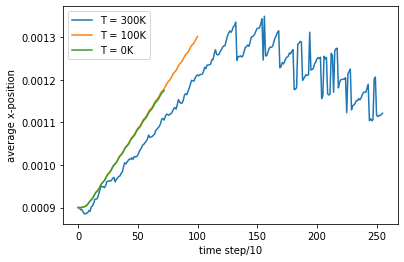

In [2061]:
plot(avg_pos_x, label = "T = 300K")
plot(avg_pos_x_highres_lofluct, label = "T = 100K")
plot(avg_pos_x_highres_nofluct, label = "T = 0K")

#plot(avg_pos_x_highres_sparse)
#plot(avg_pos_x_highres, label = "$\mathrm{d}x = h/2$")
#plot(avg_pos_x_lowres,  label = "$\mathrm{d}x = h$")
xlabel("time step/10")
ylabel("average x-position")
legend();

#savefig("xvst.pdf")

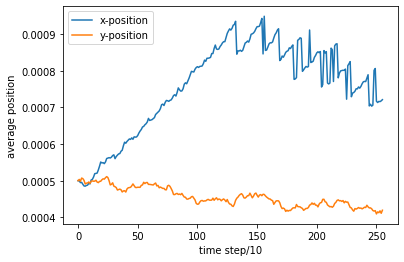

In [2062]:
plot(np.array(avg_pos_x)-0.0004, label = "x-position")
plot(np.array(avg_pos_y), label = "y-position")

xlabel("time step/10")
ylabel("average position")
#grid()
legend();

#savefig("xyvst.pdf")

In [1824]:
#avg_pos_x_highres_lofluct = avg_pos_x
#avg_pos_x_highres_nofluct = avg_pos_x
#avg_pos_x_highres_sparse = avg_pos_x
#avg_pos_x_highres_slow = avg_pos_x
#avg_pos_x_highres = avg_pos_x
#avg_pos_x_lowres = avg_pos_x

In [891]:
ds.field_list

[('boxlib', 'averaged_velx'),
 ('boxlib', 'averaged_vely'),
 ('boxlib', 'averaged_velz'),
 ('boxlib', 'divergence'),
 ('boxlib', 'pres'),
 ('boxlib', 'shifted_velx'),
 ('boxlib', 'shifted_vely'),
 ('boxlib', 'shifted_velz'),
 ('boxlib', 'tracer')]

In [31]:
ds.particle_field_by_type


AttributeError: 'BoxlibDataset' object has no attribute 'particle_field_by_type'

In [ ]:
ad = ds.all_data()
aos = AoS(ad)

In [ ]:
for i, part in enumerate(aos.particles):
    print(part.pos)

In [ ]:
p = aos.particles[1]


In [ ]:
p.annotate_sphere([0.5, 0.5, 0.5], radius=(2, 'kpc'),
                  circle_args={'color':'black'})

In [ ]:
p
